In [1]:
# This file plots the elevation gradients of bus route road segments with a
# red/blue diverging color map to indicate uphill (red) and downhill (blue)
# slopes.

In [34]:
import geopandas as gpd
import json
from rtree.index import Index as RTreeIndex
from shapely.geometry import LineString
from shapely.geometry import Point
import matplotlib
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import numpy as npm
import osmnx as ox
import pandas as pd
from shapely.ops import snap
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
CRS = 'EPSG:4326'
DATA_DIR = '../../data'
EXPORTS_DIR = f'{DATA_DIR}/exports'

In [4]:
def peek(df):
    print(len(df))
    display(df.head())

In [5]:
ny_road_mg = ox.load_graphml(f'{EXPORTS_DIR}/graphml/manhattan/ny.graphml')
ny_bus_mg = ox.load_graphml(f'{EXPORTS_DIR}/graphml/manhattan/routes/M11.graphml')

In [6]:
stops_df = pd.read_csv(f'{DATA_DIR}/gtfs/manhattan/stops.txt')
stops_df.head()

,stop_id,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station
0,400001,4 AV/E 10 ST,NaN,40.731342,-73.990292,NaN,NaN,0,NaN
1,400002,4 AV/E 12 ST,NaN,40.732608,-73.989958,NaN,NaN,0,NaN
2,400003,4 AV/E 13 ST,NaN,40.733936,-73.989720,NaN,NaN,0,NaN
3,400007,PARK AV S/E 21 ST,NaN,40.738976,-73.987053,NaN,NaN,0,NaN
4,400026,MADISON AV/E 63 ST,NaN,40.766274,-73.969329,NaN,NaN,0,NaN


In [7]:
stop_coord_dict = {}
INDEX_STOP_ID = 0
INDEX_STOP_LAT = 3
INDEX_STOP_LON = 4
for row in stops_df.iterrows():
    stop_coord_dict[row[1][INDEX_STOP_ID]] = (
        row[1][INDEX_STOP_LON],
        row[1][INDEX_STOP_LAT],
    )

In [8]:
trip_stop_sequence_dict = {}
with open(f'{EXPORTS_DIR}/json/manhattan/trip_stop_sequence_dict.json', 'r') as fp:
    trip_stop_sequence_dict = json.load(fp)

In [9]:
trip_keys = set(trip_stop_sequence_dict.keys())
trip_key = None
for key in trip_keys:
    if key[0:4] == 'M11,' and key[-1] == '1':
        trip_key = key
        break

In [10]:
stop_sequence = trip_stop_sequence_dict[trip_key]['1']

In [11]:
stop_coords = [stop_coord_dict[stop_id] for stop_id in stop_sequence]

In [12]:
stops_gdf = gpd.GeoDataFrame(stop_coords, columns=['lon', 'lat'])
stops_gdf['geometry'] = gpd.points_from_xy(stops_gdf['lon'], stops_gdf['lat'], crs=CRS)
stops_gdf.head()

,lon,lat,geometry
0,-73.955503,40.826647,POINT (-73.95550 40.82665)
1,-73.952145,40.827012,POINT (-73.95215 40.82701)
2,-73.953985,40.825383,POINT (-73.95399 40.82538)
3,-73.955501,40.823483,POINT (-73.95550 40.82348)
4,-73.957000,40.820863,POINT (-73.95700 40.82086)


In [13]:
def plot(road_mg, route_mg, stops_gdf, edge_colors='#ff0033'):
    # Determine bounding box for plotting.
    bbox_west = min([road_mg.nodes[n]['x'] for n in road_mg.nodes])
    bbox_east = max([road_mg.nodes[n]['x'] for n in road_mg.nodes])
    bbox_north = max([road_mg.nodes[n]['y'] for n in road_mg.nodes])
    bbox_south = min([road_mg.nodes[n]['y'] for n in road_mg.nodes])
    bbox = (bbox_north, bbox_south, bbox_east, bbox_west)
    
    # Plot all collected routes to visualize network coverage.
    fig, ax = plt.subplots(figsize=(50, 50))
    ox.plot_graph(road_mg,
                  ax=ax,
                  bgcolor='#444',
                  node_size=0,
                  show=False,
                  close=False,
                  edge_color='#3a3a3a',
                  bbox=bbox)
    
    ox.plot_graph(route_mg,
                  ax=ax,
                  bgcolor='#444',
                  node_size=0,
                  show=False,
                  close=False,
                  edge_color=edge_colors,
                  edge_linewidth=3,
                  bbox=bbox)
    
    stops_gdf.plot(ax=ax, color='#fff')
    
    ax.set_facecolor('#444')
    plt.show()

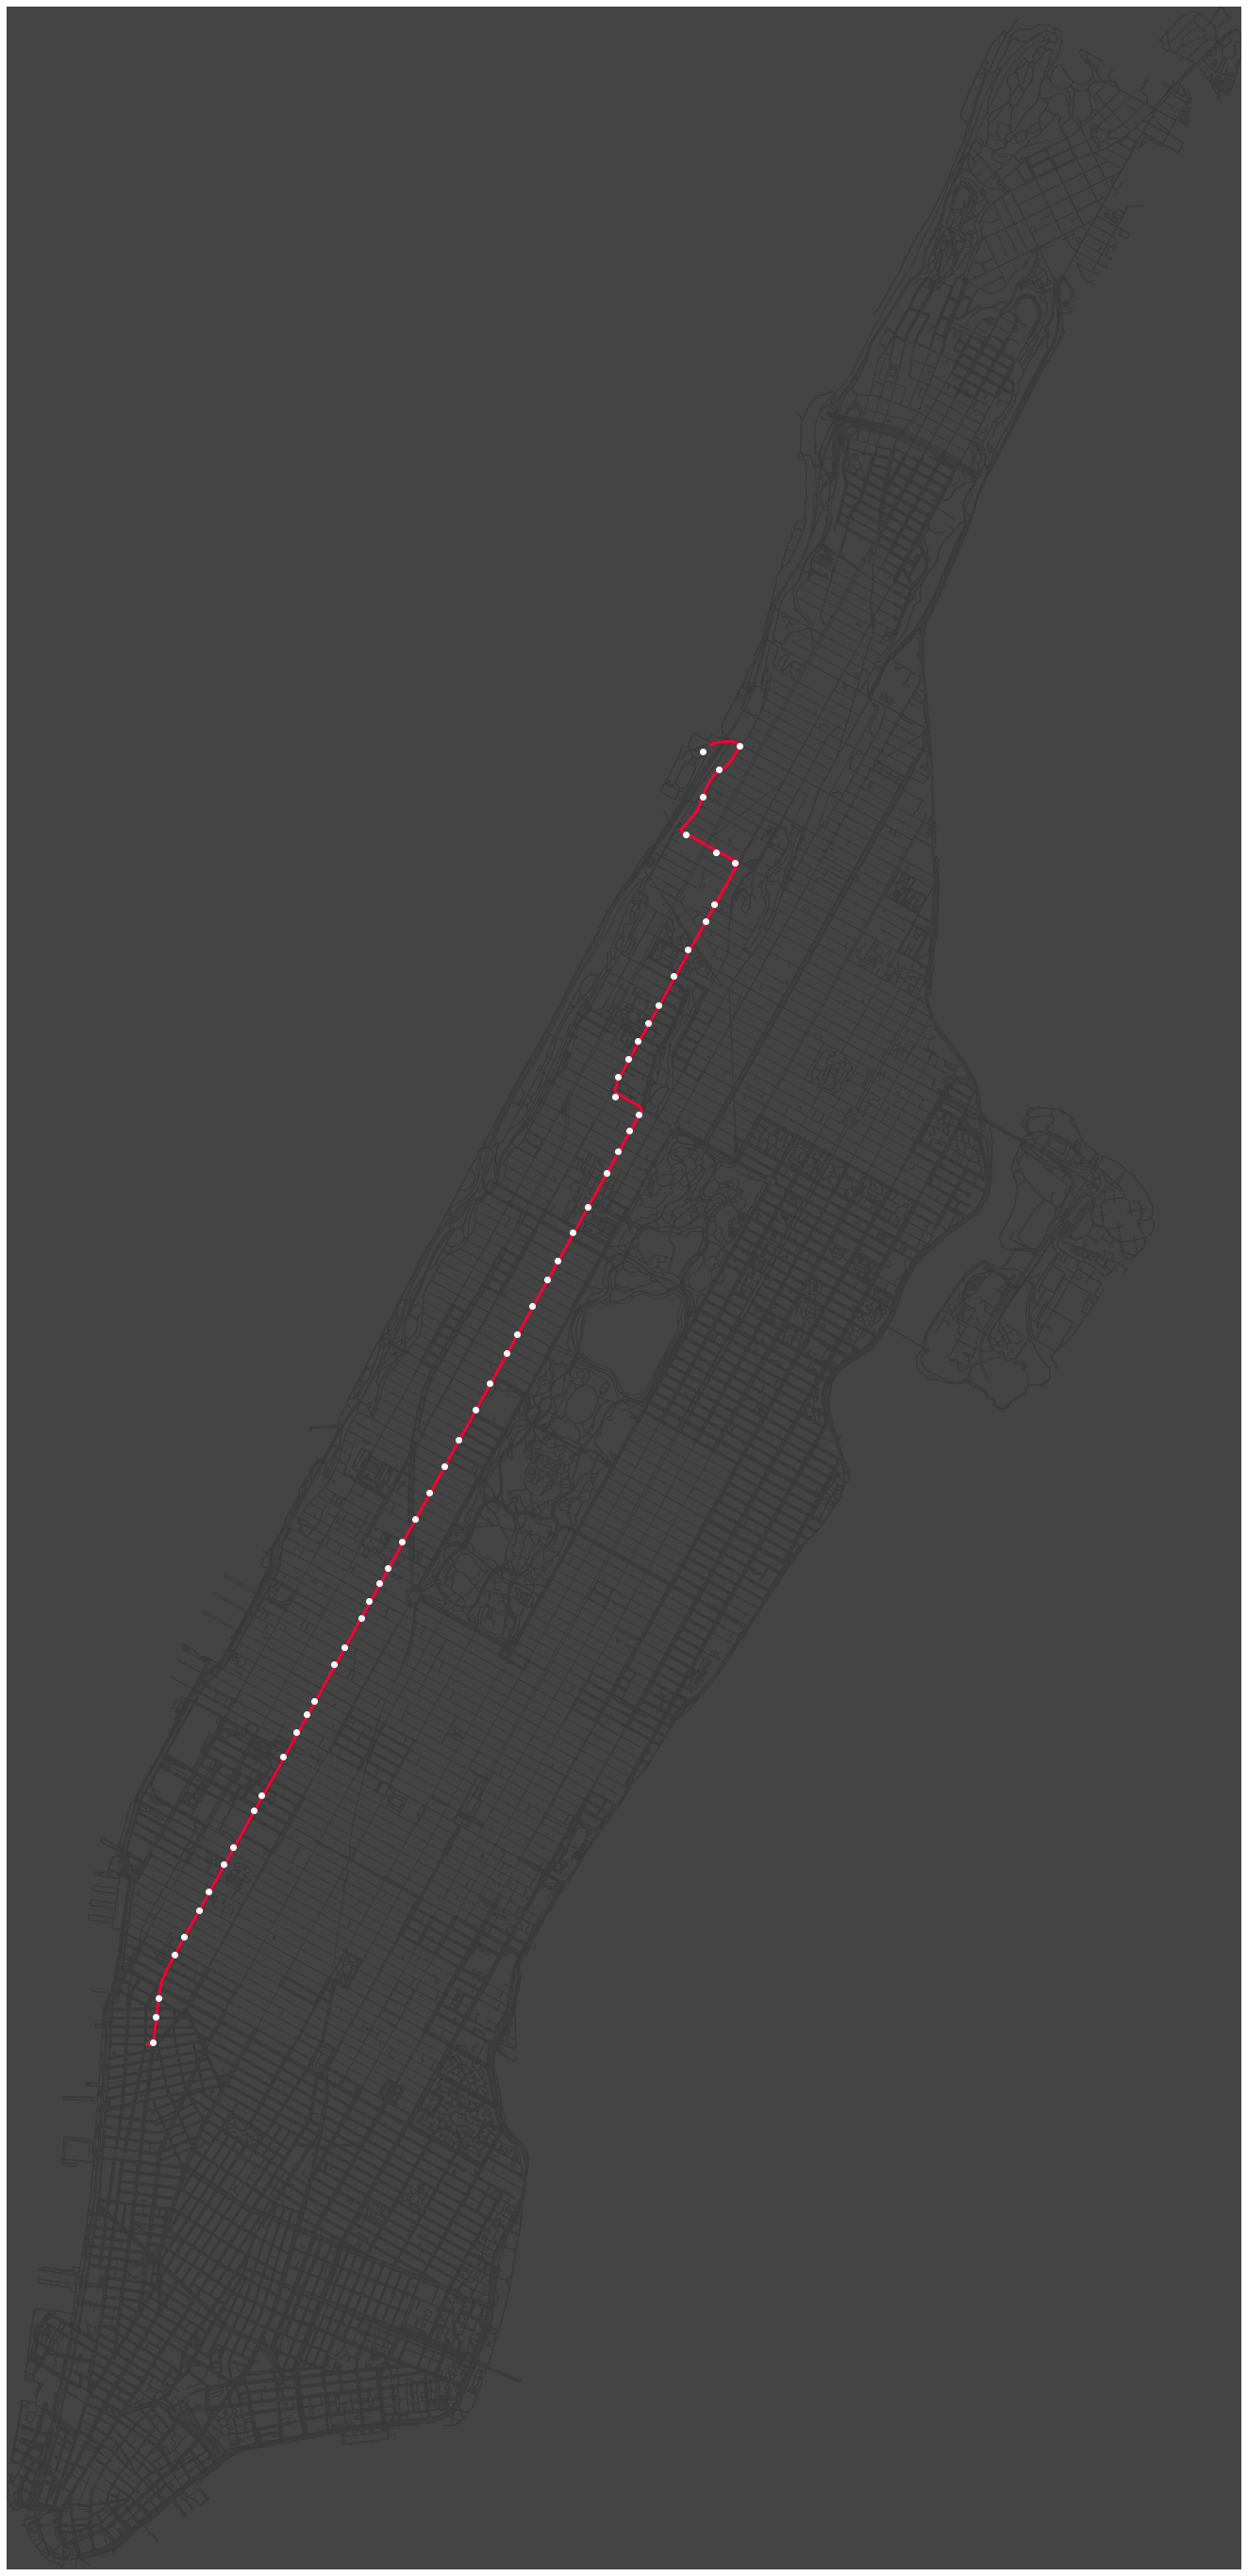

In [14]:
plot(ny_road_mg, ny_bus_mg, stops_gdf)

In [38]:
def get_geoms(mg):
    return ox.utils_graph.graph_to_gdfs(mg, nodes=False)['geometry']

def get_rtree(geoms):
    # build the r-tree spatial index by position for subsequent iloc
    rtree = RTreeIndex()
    for pos, bounds in enumerate(geoms.bounds.values):
        rtree.insert(pos, bounds)
    return rtree

def k_nearest_edges(rtree, geoms, x, y, k=3):
    # use r-tree to find possible nearest neighbors, one point at a time,
    # then minimize euclidean distance from point to the possible matches
    xy = (x, y)
    dists = geoms.iloc[list(rtree.nearest(xy))].distance(Point(xy))
    dists_df = pd.DataFrame([a[0][0:2] + (a[1],) for a in zip(dists.index, dists)], columns=['u', 'v', 'dist'])
    return dists_df.nsmallest(k, 'dist', keep='first').reset_index(drop=True)

def nearest_edges(rtree, geoms, X, Y):
    is_scalar = False
    if not (hasattr(X, "__iter__") and hasattr(Y, "__iter__")):
        # make coordinates arrays if user passed non-iterable values
        is_scalar = True
        X = np.array([X])
        Y = np.array([Y])

    if np.isnan(X).any() or np.isnan(Y).any():  # pragma: no cover
        raise ValueError("`X` and `Y` cannot contain nulls")

    # use r-tree to find possible nearest neighbors, one point at a time,
    # then minimize euclidean distance from point to the possible matches
    ne_dist = list()
    for xy in zip(X, Y):
        dists = geoms.iloc[list(rtree.nearest(xy))].distance(Point(xy))
        ne_dist.append((dists.idxmin(), dists.min()))
    ne, dist = zip(*ne_dist)

    # convert results to correct types for return
    ne = list(ne)
    dist = list(dist)
    if is_scalar:
        ne = ne[0]
        dist = dist[0]

    return ne

def snap_to_edge(mg, point, edge):
    u = edge[0]
    v = edge[1]
    
    ux = mg.nodes[u]['x']
    uy = mg.nodes[u]['y']
    vx = mg.nodes[v]['x']
    vy = mg.nodes[v]['x']
    
    line_string = LineString([(ux, uy), (vx, vy)])
    
    return snap(point, line_string, tolerance=100)

In [39]:
ny_bus_geoms = get_geoms(ny_bus_mg)
ny_bus_rtree = get_rtree(ny_bus_geoms)

In [42]:
edge_stops_gdf = stops_gdf
edge_stops_gdf['geometry'] = [snap_to_edge(ny_bus_mg, row['geometry'], row['edge']) for i, row in stops_gdf.iterrows()]
edge_stops_gdf = edge_stops_gdf.set_crs(CRS)
edge_stops_gdf

,lon,lat,geometry,edge,edge_lon,edge_lat
0,-73.955503,40.826647,POINT (-73.95491 40.82706),"(1332843726, 42434264, 0)",-73.954911,40.826647
1,-73.952145,40.827012,POINT (-73.95198 40.82708),"(42434264, 42441953, 0)",-73.951979,40.827012
2,-73.953985,40.825383,POINT (-73.95368 40.82543),"(6979088367, 7491182059, 0)",-73.953680,40.825383
3,-73.955501,40.823483,POINT (-73.95544 40.82357),"(7491182059, 7491182052, 0)",-73.955445,40.823483
4,-73.957000,40.820863,POINT (-73.95753 40.82116),"(7620631148, 42428892, 0)",-73.957529,40.820863
5,-73.954283,40.819614,POINT (-73.95502 40.82009),"(561035349, 42438836, 0)",-73.955016,40.819614
6,-73.952530,40.818923,POINT (-73.95272 40.81823),"(42435997, 42438836, 0)",-73.952721,40.818923
7,-73.954424,40.816009,POINT (-73.95408 40.81636),"(42438247, 42442596, 0)",-73.954077,40.816009
8,-73.955250,40.814859,POINT (-73.95500 40.81511),"(42442592, 42442589, 0)",-73.955000,40.814859
9,-73.956867,40.812905,POINT (-73.95661 40.81291),"(7598688515, 6993051360, 0)",-73.956615,40.812905


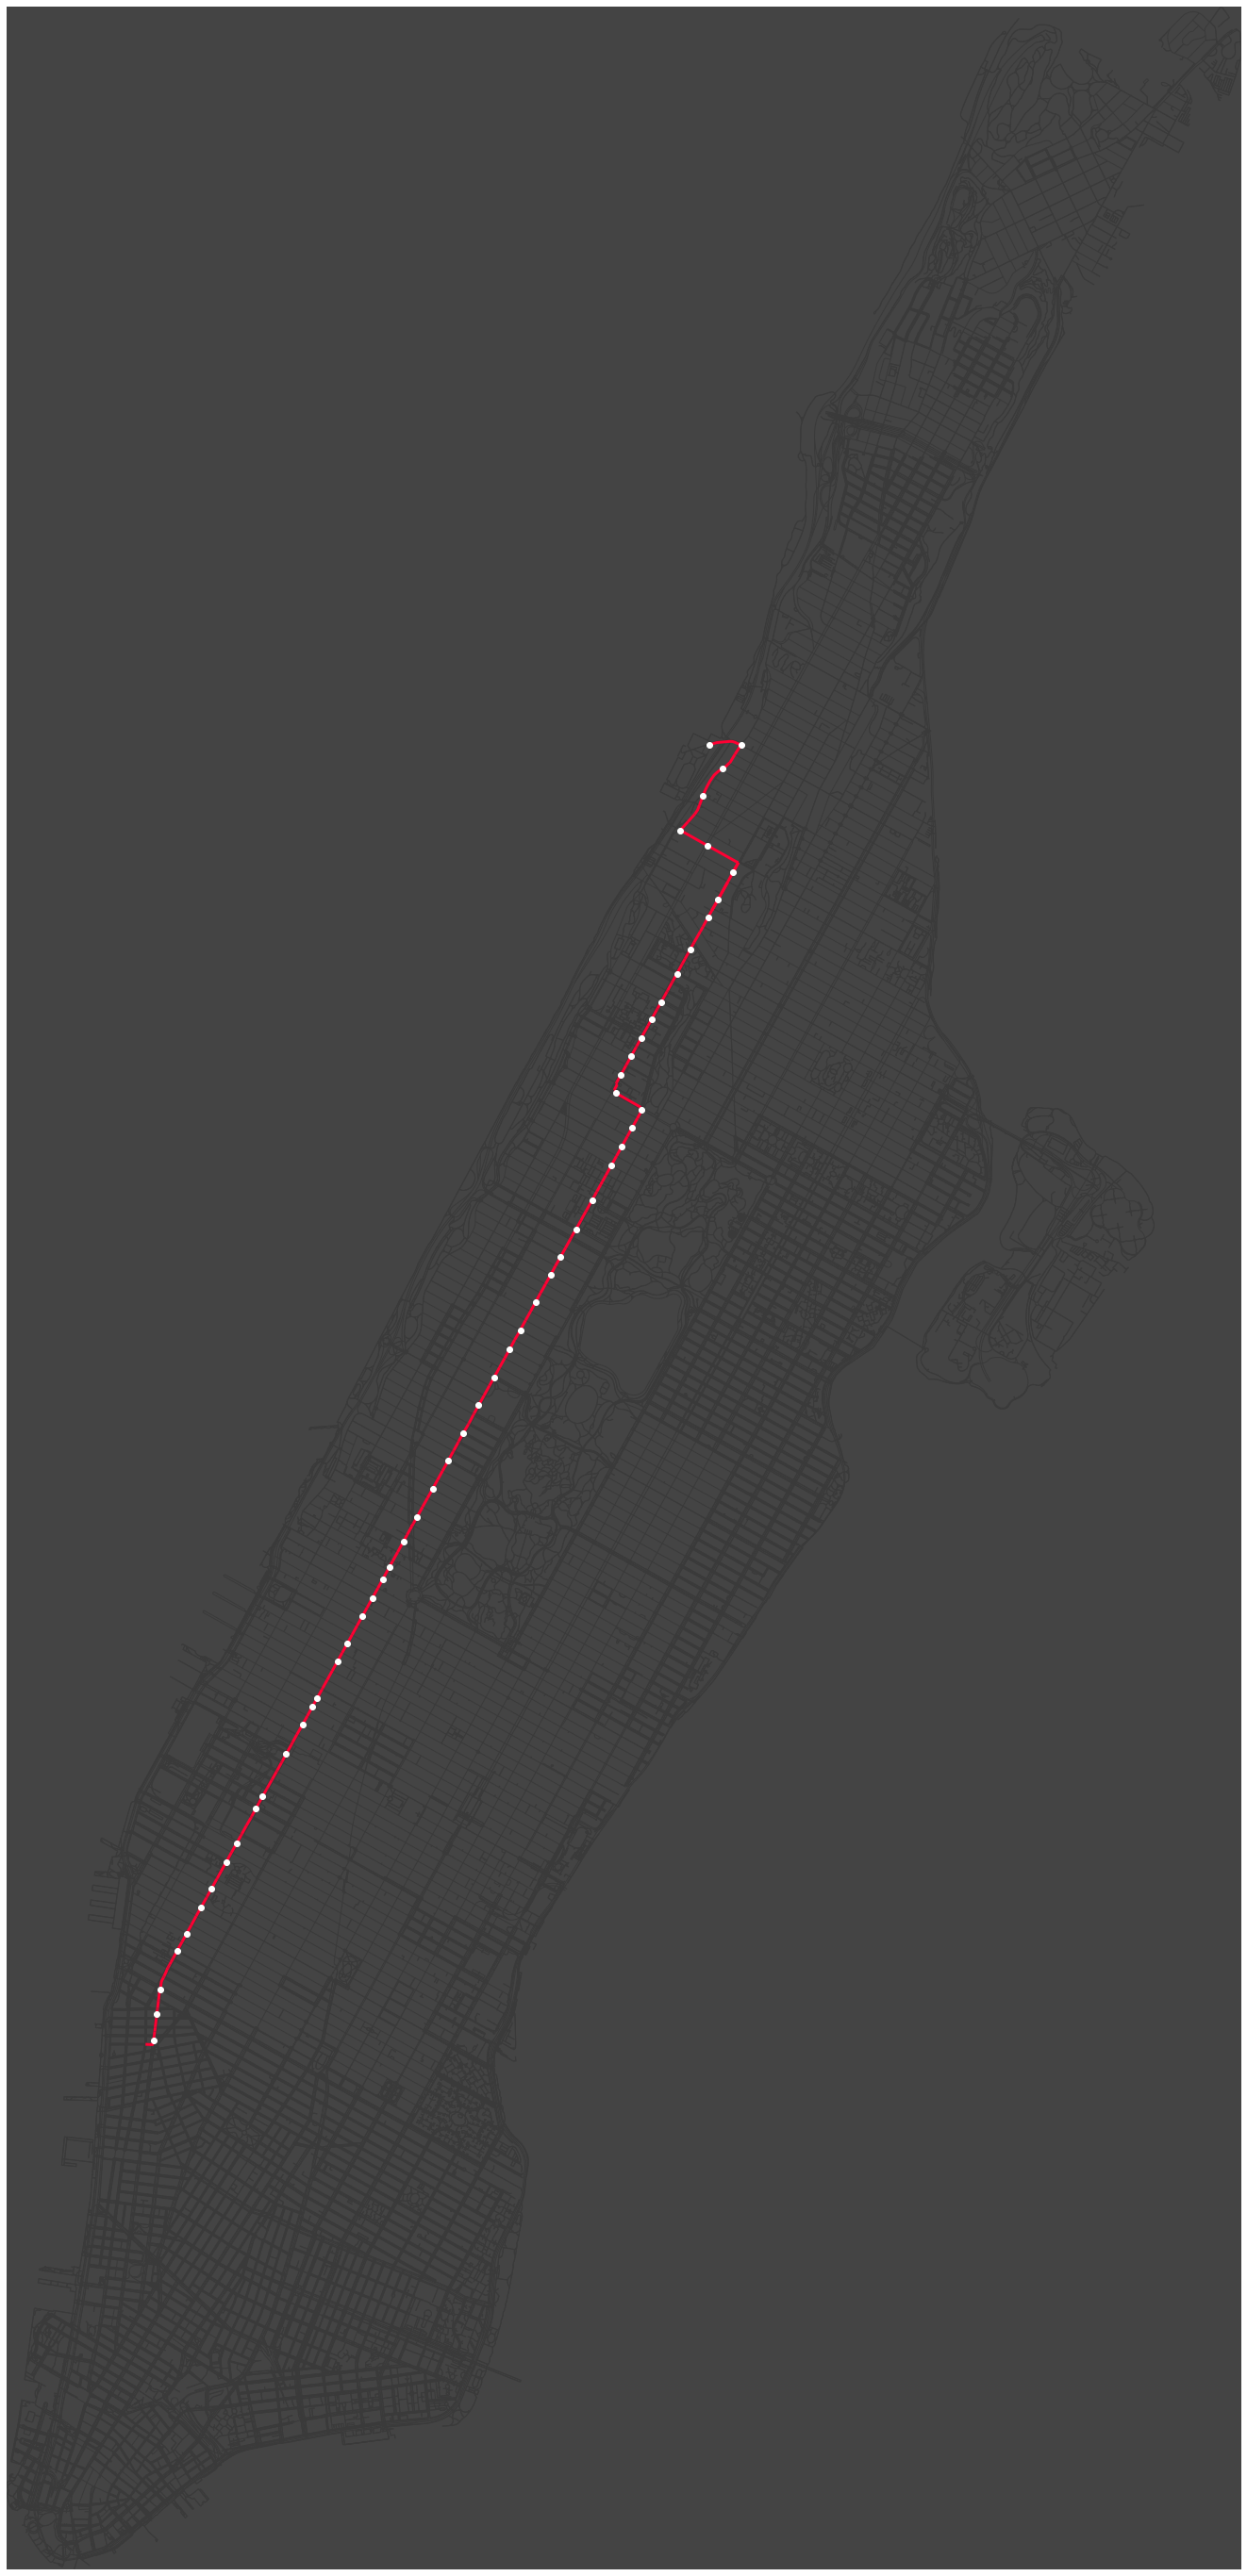

In [43]:
plot(ny_road_mg, ny_bus_mg, edge_stops_gdf)